In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import copy
import pickle

In [2]:
df_test=pd.read_csv('df_test.csv')
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [3]:
# def load_dataset(data_file):
#   df = pd.read_csv(data_file)
#   texts = df['message'].tolist()
#   labels = df['sentiment'].tolist()
#   return texts, labels

In [4]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        # text = self.texts[idx]
        text = str(self.texts[idx]) # Convert text to string
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [5]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes, dropout):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [6]:
def evaluate(model, df_test, batch_size=16):
    X_test = df_test['message'].values
    y_test = df_test['sentiment'].values

    test_texts = X_test.tolist()
    test_labels =y_test.tolist()
    
    test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, max_length)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device).squeeze(1)
            attention_mask = batch['attention_mask'].to(device)
            labels_batch = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            preds = outputs.argmax(dim=1)

            total_correct += (preds == labels_batch).sum().item()
            total_samples += input_ids.size(0)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels_batch.cpu().tolist())

    accuracy = total_correct / total_samples
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    target_names = ['0', '1', '2']
    class_report = classification_report(all_labels, all_preds, target_names=target_names, digits=4)
    conf_matrix = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])

    print(f"Test Accuracy: {accuracy:.3f}")
    print(f"Test Weighted F1 Score: {f1:.3f}")
    print("---------------------------------------------------------------------")
    print(f"Test Data:\n{class_report}")
    print(f"COnfusion Matrix:\n{conf_matrix}")
    
    df_hasil = pd.DataFrame({
        'Teks Asli': df_test['message'],
        'Aktual': all_labels,
        'Prediksi': all_preds
    })
    
    df_hasil['Hasil'] = np.where(df_hasil['Aktual'] == df_hasil['Prediksi'], 'Benar', 'Salah')
    
    print("\n\n===== TABEL SAMPEL HASIL PREDIKSI PER DATA =====")

    return f1, class_report, conf_matrix, df_hasil

In [7]:
    bert_model_name = 'bert-base-uncased'
    num_classes = 3
    max_length = 256
    batch_size = 64
    num_epochs = 2
    num_folds = 2
    learning_rate = 5e-5
    dropout = 0.2
    
    df_test= pd.read_csv('df_test.csv')
    df_test = df_test.dropna(subset=['message'])
    label_mapping = {-1: 0, 0: 1, 1: 2}
    # df_train['sentiment'] = df_train['sentiment'].map(label_mapping)
    df_test['sentiment'] = df_test['sentiment'].map(label_mapping)
    
    bestest_model = BERTClassifier(bert_model_name, 3, 0.3)
    bestest_model.load_state_dict(torch.load("best_model_bert_final.pt", map_location=torch.device('cuda'), weights_only=False))
    bestest_model.to(torch.device('cuda'))


BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [8]:
f1, class_report, conf_matrix, df_hasil_bert = evaluate(bestest_model, df_test)

Test Accuracy: 0.730
Test Weighted F1 Score: 0.737
---------------------------------------------------------------------
Test Data:
              precision    recall  f1-score   support

           0     0.4684    0.7221    0.5682       770
           1     0.5819    0.5454    0.5631      1498
           2     0.8667    0.7988    0.8314      4120

    accuracy                         0.7301      6388
   macro avg     0.6390    0.6888    0.6542      6388
weighted avg     0.7519    0.7301    0.7367      6388

COnfusion Matrix:
[[ 556  111  103]
 [ 278  817  403]
 [ 353  476 3291]]


===== TABEL SAMPEL HASIL PREDIKSI PER DATA =====


In [9]:
# df_hasil_bert.to_csv("df_hasil_bert2.csv")

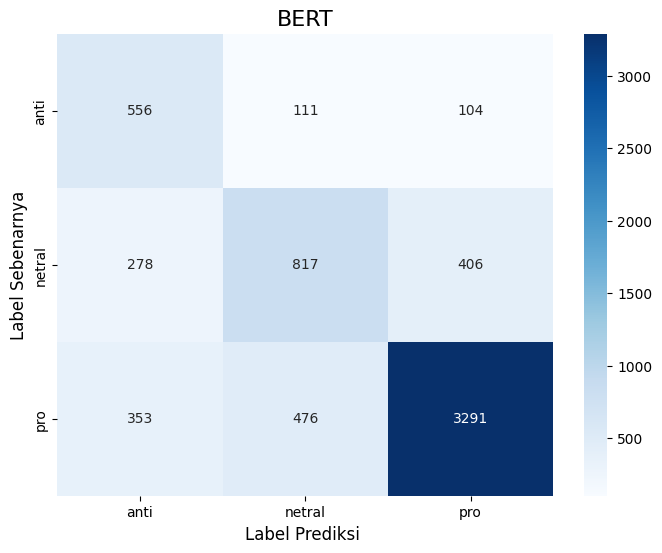

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

confusion_matrix_data = np.array([
    [556, 111, 104],
    [278, 817, 406],
    [353, 476, 3291]
])

class_names = ['anti', 'netral', 'pro']

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_data, 
            annot=True,        
            fmt='d',           
            cmap='Blues',      
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title('BERT', fontsize=16)
plt.ylabel('Label Sebenarnya', fontsize=12)
plt.xlabel('Label Prediksi ', fontsize=12)
plt.show()


In [11]:
def predict_sentence(model, sentence, tokenizer, max_length=256):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    encoding = tokenizer(
        sentence,
        return_tensors='pt',
        max_length=max_length,
        padding='max_length',
        truncation=True
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        pred = outputs.argmax(dim=1).item()

    label_names = ['Anti', 'Netral', 'Pro']

    print(f"Teks: {sentence}")
    print(f"Prediksi Sentimen: {label_names[pred]} (kelas: {pred})")

    return pred


In [21]:
predict_sentence(bestest_model, "it's getting hotter everyday because of climate change", tokenizer, max_length=256)

Teks: it's getting hotter everyday because of climate change
Prediksi Sentimen: Pro (kelas: 2)


2

In [22]:
predict_sentence(bestest_model, "I don't think climate change is fake", tokenizer, max_length=256)

Teks: I don't think climate change is fake
Prediksi Sentimen: Anti (kelas: 0)


0

In [23]:
predict_sentence(bestest_model, "Can i see climate change happening right now?" , tokenizer, max_length=256)

Teks: Can i see climate change happening right now?
Prediksi Sentimen: Netral (kelas: 1)


1